In [ ]:
# !pip install shap
# !pip install lightfm
# !pip install catboost
# !pip install pyarrow

# 0. Configuration

In [ ]:
INTERACTIONS_PATH = 'https://drive.google.com/file/d/1-D2I1KrjdJGSUmdzWlAIcwFTkVsveqft/view?usp=share_link'
# ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/1aHmS2LweBJCzNjUTxhYlPX5mbitcTU2Z/view?usp=share_link'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/1-6CEu02dbSNazHBo4hElBq2T2tX3ZY5o/view?usp=share_link'
USERS_METADATA_PATH = 'https://drive.google.com/file/d/1aJDGjCRwfMnIC1-RKTgGAsr-sOyjM6fY/view?usp=share_link'

# 1. Modules and functions

In [ ]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from typing import List
from collections import Counter

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. 1. Helper functions to avoid copy paste

In [ ]:
def read_parquet_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_parquet(file_path, engine='pyarrow')

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [ ]:
# interactions data
interactions = read_parquet_from_gdrive(INTERACTIONS_PATH)
interactions.sample(5)

,year,month,day,user_id,movie_id,watch_duration_minutes,datetime,watched_pct
922296,2022,11,17,228059660,fd8ce585-39b2-457d-8779-6d19f2d337a5,44.517,2022-11-17,33.982
1281240,2022,12,5,71307875,5500ac94-eb17-4588-b1fb-423f49b68df4,100.500,2022-12-05,96.635
1332850,2022,12,7,203030838,09ad6c80-43a5-4afe-aa59-d413dafca498,42.983,2022-12-07,40.937
574728,2022,10,29,211196885,0909a5c0-f49f-47ba-bdd3-bb58ae61df23,229.300,2022-10-29,266.628
207777,2022,10,11,211191555,aa95d980-55ad-4631-8b1a-bbfb4eea5663,75.900,2022-10-11,90.357


`users_metadata` dataset shows the list of user features existing on OKKO platform:

In [ ]:
# information about users etc
users_metadata = read_parquet_from_gdrive(USERS_METADATA_PATH)
users_metadata.sample(5)

,user_id,fav_actors,fav_director,fav_genres,fav_country,kids_flg
23791,662494,Александр Боярский,Константин Феоктистов,Драмы,США,1.000
71110,228136927,Алексей Макаров,Кирилл Алехин,Комедии,Россия,0.000
95330,239048935,Али Мухаммад,Джесси Джонсон,Вестерны,Канада,0.000
94308,239029142,Андрей Шишков,Антон Ланшаков,Комедии,Россия,1.000
106457,219461054,Аарон Фриш,Джон Майкл МакДона,Детективы,Австрия,0.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [ ]:
# information about films etc
movies_metadata = read_parquet_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.sample(5)

,movie_id,title,entity_type,genres,actors,director,country,release_world,age_rating,duration,...,Япония,Мультфильм,Сезон,Сериал,Серия,Серия многосерийного фильма,Фильм,watch_duration_minutes_mean_by_movie,movie_meta_emb,movie_cast_emb
124007,eda487f1-38ce-4d0e-824c-069e2c967b67,Континуум,Серия,"[Боевики, Триллеры, Фантастика]","[Лекса Дойг, Эрик Кнудсен, Рэйчел Николс, Брай...","[Пэт Уильямс, Дэвид Фрэйзи, Уильям Варинг]",[Канада],2012-05-27,16.000,42.000,...,0,0,0,0,1,0,0,NaN,-0.676,-0.956
29329,b1bf6ee2-0b33-4f83-af83-f302b6fce592,Курс биологии,Серия,[Комедии],"[Пэттон Освальт, Гленн Хауэртон, Лайрик Льюис,...","[Кэти Лок О’Брайэн, Эндрю ДеЯнг, Османи Родригес]",[США],2018-02-01,18.000,21.000,...,0,0,0,0,1,0,0,NaN,-0.098,-1.052
223983,b8455a4c-175f-4b79-bfde-4dcf40ca6976,Американская история преступлений,Серия,[Драмы],"[Джон Траволта, Кортни Б. Вэнс, Кьюба Гудинг м...","[Райан Мёрфи, Джон Синглтон, Энтони Хемингуэй]",[США],2016-02-02,18.000,56.000,...,0,0,0,0,1,0,0,NaN,-0.797,-0.881
135301,0c88c463-78b2-40b9-a6a4-dae194a71255,Зона комфорта,Серия,[Комедии],"[Евгений Сытый, Гарик Харламов, Степан Девонин...",[Михаил Шулаев],[Россия],2020-10-22,18.000,27.000,...,0,0,0,0,1,0,0,NaN,-0.406,-0.962
43782,676be5ff-5c64-4e18-aca3-5145a0451c0e,Можно и нельзя,Фильм,"[Короткий метр, Мультфильмы]","[Елена Понсова, Александр Граве, Клара Румянова]",[Лев Мильчин],[СССР],1964-02-01,0.000,19.000,...,0,0,0,0,0,0,1,17.000,-0.127,-0.616


In [ ]:
interactions = interactions[['user_id', 'movie_id', 'datetime', 'watch_duration_minutes', 'watched_pct']]
interactions.sample(5)

,user_id,movie_id,datetime,watch_duration_minutes,watched_pct
115247,239096641,c9f9a80a-13da-4614-9284-52ec7518ed9d,2022-10-06,34.133,31.605
1129779,228171881,d7bba92c-ffa1-4947-8096-6fad13f40790,2022-11-27,43.117,42.271
1134429,75756298,a8749d17-85fc-4ccf-ba56-75991c3a9da4,2022-11-27,1.900,1.418
283269,228057470,9cd4b771-64c8-4959-aad4-280f74ac971e,2022-10-15,62.517,71.042
102686,219181199,b0ba5c36-ae83-49fe-b03e-9fed6d0e43e7,2022-10-06,55.933,5.690


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [ ]:
interactions_merged = interactions.merge(movies_metadata, how='left')

In [ ]:
interactions['watch_duration_minutes_cumsum'] = interactions_merged[(interactions_merged['entity_type'] == 'Сериал')].groupby(['user_id', 'movie_id']).cumsum()['watch_duration_minutes']
interactions['watched_pct_cumsum'] = interactions_merged[(interactions_merged['entity_type'] == 'Сериал')].groupby(['user_id', 'movie_id']).cumsum()['watched_pct']

In [ ]:
interactions['watch_duration_minutes_cumsum'] = interactions['watch_duration_minutes_cumsum'].fillna(interactions['watch_duration_minutes'])
interactions['watched_pct_cumsum'] = interactions['watched_pct_cumsum'].fillna(interactions['watched_pct'])

In [ ]:
del interactions_merged

In [ ]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['watch_duration_minutes_cumsum'] > 20].reset_index(drop = True)

In [ ]:
print(interactions.shape, interactions_filtered.shape)

(1800000, 7) (1164164, 7)


In [ ]:
interactions_filtered['datetime'] = pd.to_datetime(interactions_filtered['datetime'])

In [ ]:
# set dates params for filter
MAX_DATE = interactions_filtered['datetime'].max()
MIN_DATE = interactions_filtered['datetime'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2022-12-30 00:00:00
max date in filtered interactions:: 2022-10-01 00:00:00


In [ ]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [ ]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['datetime'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['datetime'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(969393, 7) (194771, 7)


In [ ]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['datetime'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2022-11-23 00:00:00


In [ ]:
global_train = global_train.dropna().reset_index(drop = True)

In [ ]:
local_train = global_train.loc[global_train['datetime'] < local_train_thresh]
local_test = global_train.loc[global_train['datetime'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(667617, 7) (301776, 7)


In [ ]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(251972, 7)


In [ ]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['movie_id'].unique())

In [ ]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [ ]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  86321
user features mapper length -  86321
movies mapper length -  12354
Users movie features mapper length -  12354


In [ ]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [ ]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [ ]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'movie_id']]))

In [ ]:
train_mat

<86321x12354 sparse matrix of type '<class 'numpy.int32'>'
	with 667617 stored elements in COOrdinate format>

In [ ]:
train_mat_weights

<86321x12354 sparse matrix of type '<class 'numpy.float32'>'
	with 667617 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [ ]:
# set params - last HW
# NO_COMPONENTS = 10
# LEARNING_RATE = .05
# LOSS = 'logistic'
# MAX_SAMPLED = 10
# RANDOM_STATE = 42
# EPOCHS = 10

# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [ ]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [ ]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 150513, row number in matrix - 72


In [ ]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

12354

In [ ]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 3.0393474 ,  0.5751401 , -0.86676985, ..., -2.1388266 ,
        -1.8979303 , -1.8813995 ], dtype=float32),
 (12354,))

In [ ]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([    0,  9980,  7893,    12, 11019,  8641, 11018, 11640, 11026,
          45])

In [ ]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['movie_id'], movies_metadata['title']))

In [ ]:
recs = pd.DataFrame({'col_id': top_cols})
recs['movie_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['movie_id'].map(item_name_mapper)
recs

,col_id,movie_id,title
0,0,91f9d892-a508-4962-91e9-abacd93e0830,1703
1,9980,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,Кунгур
2,7893,703b202e-1774-4b93-8a0c-e848d7d3abcc,Начать сначала
3,12,25ef7e77-d83d-46d1-999a-ca36a045ab9a,Химера
4,11019,5a3bf8a0-3054-448b-b524-025abea0cac3,Аксентьев
5,8641,28509b56-b1b5-4568-93d6-de7611ef5a2e,Лэйт Найт Скул
6,11018,e5f48804-89a0-45d0-900b-5e88d465954f,Красная Шапочка
7,11640,ec0a8ccf-f614-4124-8fd3-dade8dace293,Суперпозиция
8,11026,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,Три тысячи лет желаний
9,45,9c98f362-737c-47eb-a500-046c998fa888,Дикая


In [ ]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 219132313, row number in matrix - 671


In [ ]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([ 2.8953729 ,  0.12735814, -1.2256874 , ..., -2.1737726 ,
        -2.0924094 , -2.049193  ], dtype=float32),
 (12354,))

In [ ]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([    0,  9980,  6842, 11019,    74, 11018,    65,  8641,   216,
        7893])

In [ ]:
recs = pd.DataFrame({'col_id': top_cols})
recs['movie_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['movie_id'].map(item_name_mapper)
recs

,col_id,movie_id,title
0,0,91f9d892-a508-4962-91e9-abacd93e0830,1703
1,9980,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,Кунгур
2,6842,d722f09d-a99d-4c7f-853c-0c77fcd45f35,Барбоскины Team
3,11019,5a3bf8a0-3054-448b-b524-025abea0cac3,Аксентьев
4,74,3cfb5023-3c07-4384-8acf-d488d5a0ffa4,Ворона
5,11018,e5f48804-89a0-45d0-900b-5e88d465954f,Красная Шапочка
6,65,537ece24-2358-4108-a419-85cfd5952607,Пес-самурай и город кошек
7,8641,28509b56-b1b5-4568-93d6-de7611ef5a2e,Лэйт Найт Скул
8,216,37957168-d3fe-4273-89ee-f59a3a1d7c14,Кощей. Похититель невест
9,7893,703b202e-1774-4b93-8a0c-e848d7d3abcc,Начать сначала


In [ ]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

37784

In [ ]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [ ]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [ ]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = 30,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
)

In [ ]:
test_preds['movie_id'] = test_preds['user_id'].map(mapper)

In [ ]:
test_preds = test_preds.explode('movie_id')
test_preds.shape

(1133520, 2)

In [ ]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [ ]:
test_preds.head()

,user_id,movie_id,rank
0,56250,91f9d892-a508-4962-91e9-abacd93e0830,1
0,56250,731e42d2-e501-4e77-aba6-28e96f9e8a19,2
0,56250,d9dd799b-7669-4a85-a9d1-d42eb436229f,3
0,56250,2bbe65ab-7fa9-42cc-91f9-868f1f694ddd,4
0,56250,5b54d128-feb5-4ae6-bd32-44795b43f16c,5


In [ ]:
test_preds['movie_name'] = test_preds['movie_id'].map(item_name_mapper)
test_preds.head()

,user_id,movie_id,rank,movie_name
0,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,1703
0,56250,731e42d2-e501-4e77-aba6-28e96f9e8a19,2,Громкая связь
0,56250,d9dd799b-7669-4a85-a9d1-d42eb436229f,3,О чём говорят мужчины
0,56250,2bbe65ab-7fa9-42cc-91f9-868f1f694ddd,4,Обратная связь
0,56250,5b54d128-feb5-4ae6-bd32-44795b43f16c,5,Последний богатырь: Посланник Тьмы


In [ ]:
test_preds['user_id'].unique().shape

(37784,)

In [ ]:
test_preds.shape[0] / test_preds['user_id'].unique().shape[0]

30.0

In [ ]:
# sense check for diversity of recommendations
test_preds['movie_id'].nunique()

4057

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative event -- 0 otherwise

In [ ]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'movie_id'])
positive_preds['target'] = 1
positive_preds.shape

(36348, 10)

In [ ]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'movie_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct_cumsum'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(221406, 10)

In [ ]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [ ]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [ ]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [ ]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:             user_id       rank  watch_duration_minutes  watched_pct  \
count    206263.000 206263.000               29118.000    29118.000   
mean  154963485.476     15.003                  69.497       64.308   
std    97523805.784      8.763                  42.997       46.961   
min       56250.000      1.000                   0.017        0.000   
25%    23917743.500      7.000                  40.000       28.889   
50%   211277358.000     15.000                  64.983       64.574   
75%   228376221.000     23.000                  91.233       93.527   
max   239439176.000     30.000                 787.650      896.462   

       watch_duration_minutes_cumsum  watched_pct_cumsum     target  
count                      29118.000           29118.000 206263.000  
mean                          73.286              65.478      0.141  
std                           45.068              46.540      0.348  
min                           20.017               0.224      0.000  
25%

In [ ]:
new_features_list = ['0.0',
 '12.0',
 '16.0',
 '6.0',
 'for_adults',
 'for_kids',
 'main_actor',
 'main_country',
 'main_director',
 'main_genre',
 'movie_cast_emb',
 'movie_meta_emb',
 'popularity_country',
 'popularity_genres',
 'popularity_movie_id',
 'watch_duration_minutes_mean_by_movie',
 'year',
 'year_cat',
 'year_cat_1900s',
 'year_cat_1910s',
 'year_cat_1920s',
 'year_cat_1930s',
 'year_cat_1940s',
 'year_cat_1950s',
 'year_cat_1960s',
 'year_cat_1970s',
 'year_cat_1980s',
 'year_cat_1990s',
 'year_cat_2000s',
 'year_cat_2010s',
 'year_cat_2020s',
 'year_cat_Unknown_release_year',
 'Абхазия',
 'Австралия',
 'Австрия',
 'Азербайджан',
 'Албания',
 'Алжир',
 'Аниме',
 'Аргентина',
 'Армения',
 'Артхаус',
 'Аруба',
 'Афганистан',
 'Багамы',
 'Бахрейн',
 'Белоруссия',
 'Бельгия',
 'Биографии',
 'Блоги',
 'Боевики',
 'Болгария',
 'Босния-Герцеговина',
 'Ботсвана',
 'Бразилия',
 'Бутан',
 'Ватикан',
 'Великобритания',
 'Венгрия',
 'Венесуэла',
 'Вестерны',
 'Видеообзор',
 'Викторина',
 'Военное',
 'Вьетнам',
 'Гваделупа',
 'Германия',
 'Германия (ГДР)',
 'Германия (ФРГ)',
 'Гонконг',
 'Греция',
 'Грузия',
 'Дания',
 'Детективы',
 'Документальное',
 'Доминикана',
 'Драмы',
 'Египет',
 'Замбия',
 'Зимбабве',
 'Израиль',
 'Индия',
 'Индонезия',
 'Интервью',
 'Иран',
 'Ирландия',
 'Искусство',
 'Исландия',
 'Испания',
 'Историческое',
 'Италия',
 'Казахстан',
 'Каймановы острова',
 'Камбоджа',
 'Камерун',
 'Канада',
 'Караоке',
 'Катар',
 'Кения',
 'Кипр',
 'Киргизия',
 'Китай',
 'Колумбия',
 'Комедии',
 'Конго',
 'Конференции',
 'Концерты',
 'Корея Северная',
 'Корея Южная',
 'Короткий метр',
 'Криминальное',
 'Куба',
 'Курсы',
 'Кыргызстан',
 'Латвия',
 'Лекции',
 'Либерия',
 'Ливан',
 'Литва',
 'Лихтенштейн',
 'Люксембург',
 'Македония',
 'Малайзия',
 'Мальта',
 'Марокко',
 'Мексика',
 'Мелодрамы',
 'Монако',
 'Музыкальное',
 'Мультфильм',
 'Мультфильмы',
 'Намибия',
 'Нигерия',
 'Нидерланды',
 'Новая Зеландия',
 'Норвегия',
 'ОАЭ',
 'Остров Мэн',
 'Пакистан',
 'Панама',
 'Папуа - Новая Гвинея',
 'Парагвай',
 'Перу',
 'Польша',
 'Португалия',
 'Презентации',
 'Приключения',
 'Природа',
 'Путешествия',
 'Пуэрто Рико',
 'Реюньон',
 'Россия',
 'Руанда',
 'Румыния',
 'СССР',
 'США',
 'Саудовская Аравия',
 'Сезон',
 'Сейшельские острова',
 'Семейное',
 'Сенегал',
 'Сербия',
 'Сериал',
 'Серия',
 'Серия многосерийного фильма',
 'Сингапур',
 'Словакия',
 'Словения',
 'Советское',
 'Спорт',
 'ТВ-шоу',
 'Таджикистан',
 'Таиланд',
 'Тайвань',
 'Танзания',
 'Театр',
 'Триллеры',
 'Тунис',
 'Турция',
 'Уганда',
 'Ужасы',
 'Узбекистан',
 'Украина',
 'Уругвай',
 'Фантастика',
 'Филиппины',
 'Фильм',
 'Фильмы для детей',
 'Финляндия',
 'Фитнес',
 'Франция',
 'Фэнтези',
 'Хорватия',
 'Черногория',
 'Чехия',
 'Чехословакия',
 'Чили',
 'Швейцария',
 'Швеция',
 'Шоу',
 'Шри-Ланка',
 'Эстония',
 'ЮАР',
 'Югославия (ФР)',
 'Япония']

In [ ]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['fav_actors', 'fav_director', 'fav_genres', 'fav_country', 'kids_flg']
ITEM_FEATURES = new_features_list # + movies_vectors_list

In [ ]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_metadata[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_metadata[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])

In [ ]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['movie_id'] + ITEM_FEATURES],
                         how = 'left', on = ['movie_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['movie_id'] + ITEM_FEATURES],
                        how = 'left', on = ['movie_id'])

In [ ]:
print(cbm_train_set.shape, cbm_test_set.shape)

(206263, 220) (51491, 220)


In [ ]:
cbm_train_set.columns.to_list()

['user_id',
 'movie_id',
 'rank',
 'movie_name',
 'datetime',
 'watch_duration_minutes',
 'watched_pct',
 'watch_duration_minutes_cumsum',
 'watched_pct_cumsum',
 'target',
 'fav_actors',
 'fav_director',
 'fav_genres',
 'fav_country',
 'kids_flg',
 '0.0',
 '12.0',
 '16.0',
 '6.0',
 'for_adults',
 'for_kids',
 'main_actor',
 'main_country',
 'main_director',
 'main_genre',
 'movie_cast_emb',
 'movie_meta_emb',
 'popularity_country',
 'popularity_genres',
 'popularity_movie_id',
 'watch_duration_minutes_mean_by_movie',
 'year',
 'year_cat',
 'year_cat_1900s',
 'year_cat_1910s',
 'year_cat_1920s',
 'year_cat_1930s',
 'year_cat_1940s',
 'year_cat_1950s',
 'year_cat_1960s',
 'year_cat_1970s',
 'year_cat_1980s',
 'year_cat_1990s',
 'year_cat_2000s',
 'year_cat_2010s',
 'year_cat_2020s',
 'year_cat_Unknown_release_year',
 'Абхазия',
 'Австралия',
 'Австрия',
 'Азербайджан',
 'Албания',
 'Алжир',
 'Аниме',
 'Аргентина',
 'Армения',
 'Артхаус',
 'Аруба',
 'Афганистан',
 'Багамы',
 'Бахрейн',
 

In [ ]:
ID_COLS = ['user_id', 'movie_id']
TARGET = ['target']
CATEGORICAL_COLS = ['main_actor', 'main_director', 'main_country', 'main_genre', 'fav_actors', 'fav_director', 'fav_genres', 'fav_country']
# DROP_COLS = ['movie_name', 'release_world', 'datetime', 'watched_pct', 'watch_duration_minutes', 'entity_type']
DROP_COLS = ['movie_name', 'datetime', 'watched_pct', 'watched_pct_cumsum', 'watch_duration_minutes', 'watch_duration_minutes_cumsum', 'year_cat']

In [ ]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(206263, 210) (51491, 210)


In [ ]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

In [ ]:
# oversample = SMOTE(sampling_strategy=.3)
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# X_test, y_test = oversample.fit_resample(X_test, y_test)
# print(Counter(y_train), Counter(y_test))

In [ ]:
X_train.head()

,rank,fav_actors,fav_director,fav_genres,fav_country,kids_flg,0.0,12.0,16.0,6.0,...,Чехословакия,Чили,Швейцария,Швеция,Шоу,Шри-Ланка,Эстония,ЮАР,Югославия (ФР),Япония
0,20,Рассел Кроу,Джон Уоттс,Комедии,Латвия,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,Кэмерон Диаз,Ник Кассаветис,Комедии,Франция,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,Виктор Хориняк,Дмитрий Дьяченко,Историческое,Россия,0.000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,17,Вадим Бочанов,Елена Галдобина,Ужасы,Бельгия,1.000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Андрей Мерзликин,Майкл Бэй,Ужасы,США,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206263 entries, 0 to 206262
Columns: 210 entries, rank to Япония
dtypes: float32(2), float64(6), int64(2), object(8), uint8(192)
memory usage: 66.1+ MB


In [ ]:
# X_train.columns.to_list()[23]

## 2.5.2. Train Model

In [ ]:
from sklearn.utils import class_weight

In [ ]:
np.unique(pd.concat([y_train, y_test], ignore_index=True)['target'])

array([0, 1], dtype=int64)

In [ ]:
cw = dict(zip(np.unique(pd.concat([y_train, y_test], ignore_index=True)['target']),
              list(class_weight.compute_class_weight(class_weight='balanced',
                                                     classes=np.unique(pd.concat([y_train, y_test], ignore_index=True)['target']),
                                                     y=pd.concat([y_train, y_test], ignore_index=True)['target']))
))

In [ ]:
cw

{0: 0.5820844963551123, 1: 3.5456421261142292}

In [ ]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'Logloss',
    class_weights=cw,
    iterations = 5000,
    learning_rate = .1,
    depth = 10,
    random_state = 1234,
    cat_features = CATEGORICAL_COLS,
    early_stopping_rounds=100, # to avoid overfitting,
    verbose = True
)

In [ ]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

In [ ]:
def select_features_syntetic(algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps: int = 1):
    print('Algorithm:', algorithm)
    # model = CatBoostRegressor(iterations=1000, random_seed=0)
    summary = cbm_classifier.select_features(
        X_train, y_train,
        eval_set=(X_test, y_test),
        features_for_select=list(range(X_train.shape[1])),     # we will select from all features
        num_features_to_select=25,  # we want to select exactly important features
        steps=steps,                                     # more steps - more accurate selection
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        # cat_features = CATEGORICAL_COLS,
        plot=False
    )
    # print('Selected important features: {}/{}'.format(
    #     len(set(important_features).intersection(summary['selected_features'])),
    #     len(important_features)
    # ))
    # print('Not selected important features:', set(important_features).difference(summary['selected_features']))
    return summary

In [ ]:
synthetic_shap_summary = select_features_syntetic(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Step #1 out of 1
0:	learn: 0.6652696	test: 0.6696792	best: 0.6696792 (0)	total: 1.42s	remaining: 1h 58m 12s
1:	learn: 0.6434265	test: 0.6507098	best: 0.6507098 (1)	total: 2.5s	remaining: 1h 44m 3s
2:	learn: 0.6262719	test: 0.6357350	best: 0.6357350 (2)	total: 3.73s	remaining: 1h 43m 25s
3:	learn: 0.6037150	test: 0.6182502	best: 0.6182502 (3)	total: 5.47s	remaining: 1h 53m 51s
4:	learn: 0.5837089	test: 0.6029982	best: 0.6029982 (4)	total: 7.5s	remaining: 2h 4m 51s
5:	learn: 0.5662253	test: 0.5898227	best: 0.5898227 (5)	total: 8.72s	remaining: 2h 55s
6:	learn: 0.5536755	test: 0.5801145	best: 0.5801145 (6)	total: 9.93s	remaining: 1h 58m 3s
7:	learn: 0.5408553	test: 0.5707979	best: 0.5707979 (7)	total: 11s	remaining: 1h 54m 30s
8:	learn: 0.5316546	test: 0.5643778	best: 0.5643778 (8)	total: 12.1s	remaining: 1h 52m 2s
9:	learn: 0.5229336	test: 0.5598403	best: 0.5598403 (9)	total: 13.4s	remaining: 1h 51m 51s
10:	learn: 0.5164719	tes

In [ ]:
synthetic_shap_summary.get('selected_features_names')

['rank',
 'fav_actors',
 'fav_director',
 'fav_genres',
 'fav_country',
 'kids_flg',
 'for_adults',
 'for_kids',
 'main_actor',
 'main_country',
 'main_director',
 'main_genre',
 'movie_cast_emb',
 'movie_meta_emb',
 'popularity_movie_id',
 'watch_duration_minutes_mean_by_movie',
 'year',
 'Криминальное',
 'Мелодрамы',
 'Мультфильмы',
 'США',
 'Семейное',
 'Сериал',
 'Фантастика',
 'Фэнтези']

In [ ]:
# X_train = X_train[synthetic_shap_summary.get('selected_features_names')]
# X_test = X_test[synthetic_shap_summary.get('selected_features_names')]

In [ ]:
# cbm_classifier.fit(
#     X_train, y_train,
#     eval_set=(X_test, y_test),
#     # early_stopping_rounds = 100, # to avoid overfitting,
#     # cat_features = CATEGORICAL_COLS 
# )

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [ ]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

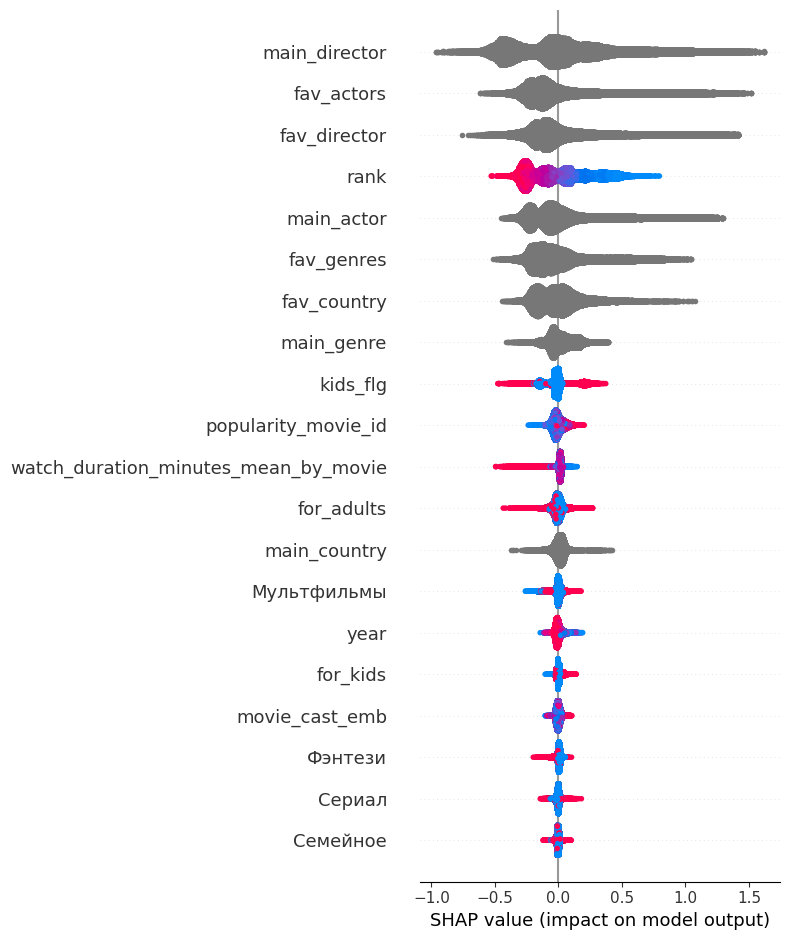

In [ ]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [ ]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [ ]:
y_test_pred[:, 1]

array([0.36516361, 0.39306672, 0.74827584, ..., 0.8089948 , 0.21357698,
       0.22192305])

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.5f}")

ROC AUC score = 0.81704


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

In [ ]:
def compute_metrics(df_true: pd.DataFrame, 
                    df_pred: pd.DataFrame, 
                    K: int, 
                    rank_col: str = 'rank') -> pd.DataFrame:

    result = pd.DataFrame(columns=['Metric', 'Value'])

    test_recs = df_true.set_index(['user_id', 'movie_id']).join(df_pred.set_index(['user_id', 'movie_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()

    for k in range(1, K + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result.loc[len(result.index)] = [f'Precision@{k}', (test_recs[hit_k] / k).sum() / users_count]

    result.loc[len(result.index)] = [f'MAP@{K}', (test_recs['cumulative_rank'] / test_recs['users_item_count']).sum() / users_count]
    result.loc[len(result.index)] = [f'MRR', test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()]

    ideal_dcg = df_true.groupby('user_id').apply(lambda x: np.sum(1 / np.log2(np.arange(2, len(x) + 2))))
    ideal_dcg = ideal_dcg.sum()
    
    predicted_dcg = test_recs.reset_index().groupby('user_id').apply(lambda x: np.sum(x[rank_col].head(K).apply(lambda r: 1 / np.log2(r + 2))))
    predicted_dcg = predicted_dcg.sum()
    
    if ideal_dcg == 0:
        ndcg = 0
    else:
        ndcg = predicted_dcg / ideal_dcg
    
    result.loc[len(result.index)] = [f'NDCG@{K}', ndcg]

    return result

In [ ]:
# we will focus on warm start - remove cold start users
global_test = global_test[global_test['user_id'].isin(local_train['user_id'].unique())]

In [ ]:
top_N = 100

# let's make predictions for all users in global test
global_test_preds = pd.DataFrame({
    'user_id': global_test['user_id'].unique()
    })

# form user-known items
known_items = {user_id: item_id_gr['movie_id'].to_list() for user_id, item_id_gr in local_train[['user_id', 'movie_id']].groupby('user_id')}

In [ ]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

global_test_preds['movie_id'] = global_test_preds['user_id'].map(mapper)
global_test_preds = global_test_preds.explode('movie_id').reset_index(drop=True)
global_test_preds['rank'] = global_test_preds.groupby('user_id').cumcount() + 1 

In [ ]:
lfm_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                              global_test_preds, 
                              K=10)
lfm_metrics

,Metric,Value
0,Precision@1,0.048
1,Precision@2,0.043
2,Precision@3,0.040
3,Precision@4,0.038
4,Precision@5,0.035
5,Precision@6,0.034
6,Precision@7,0.033
7,Precision@8,0.032
8,Precision@9,0.030
9,Precision@10,0.029


In [ ]:
global_test_lfm_ctb_preds = global_test_preds.copy()

# joins user features
global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_preds, 
                                   users_metadata[['user_id'] + USER_FEATURES],
                                   how='left', on=['user_id'])
# joins item features
global_test_lfm_ctb_set = pd.merge(global_test_lfm_ctb_set, 
                                   movies_metadata[['movie_id'] + ITEM_FEATURES],
                                   how='left', on=['movie_id'])
# global_test_lfm_ctb_set = global_test_lfm_ctb_set[synthetic_shap_summary.get('selected_features_names')]
global_test_lfm_ctb_set = global_test_lfm_ctb_set.fillna(global_test_lfm_ctb_set.mode().iloc[0])

In [ ]:
# synthetic_shap_summary.get('selected_features_names')

In [ ]:
# global_test_lfm_ctb_set.head()

In [ ]:
ctb_prediction = cbm_classifier.predict_proba(global_test_lfm_ctb_set.drop(ID_COLS + DROP_COLS, axis=1, errors='ignore'))

global_test_lfm_ctb_preds['ctb_pred'] = ctb_prediction[:, 1]
global_test_lfm_ctb_preds.head()

,user_id,movie_id,rank,ctb_pred
0,58953,3c8f2117-3853-4682-b024-814a15de1b69,1,0.293
1,58953,91f9d892-a508-4962-91e9-abacd93e0830,2,0.797
2,58953,0f33af53-5d2d-4c82-a2e9-307fcabdcb2d,3,0.680
3,58953,703b202e-1774-4b93-8a0c-e848d7d3abcc,4,0.155
4,58953,72d1b1f1-c88d-4c10-8a13-6e1533fdfef0,5,0.196


In [ ]:
global_test_lfm_ctb_preds = global_test_lfm_ctb_preds.sort_values(by=['user_id', 'ctb_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ctb_preds['rank_ctb'] = global_test_lfm_ctb_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ctb_preds.head(10)

,user_id,movie_id,rank,ctb_pred,rank_ctb
1211829,56250,925ade32-7ad1-40c3-9964-6194b395b242,30,0.886,1
1211809,56250,f40dfca2-27ef-40b3-9119-a20dfe965013,10,0.761,2
1211827,56250,7bee4e05-387f-4413-a406-cb5d1a80f1b8,28,0.733,3
1211817,56250,2160ce47-2962-4c87-9ccf-81d942ad84c8,18,0.560,4
1211837,56250,a53d1aef-c3e2-41d5-b27e-d4f05ef56b05,38,0.545,5
1211800,56250,91f9d892-a508-4962-91e9-abacd93e0830,1,0.515,6
1211812,56250,7dcc3cf7-943b-4964-9b86-a7d9ab5c767d,13,0.488,7
1211805,56250,42f5cb31-f333-426c-a95b-8e106741de38,6,0.473,8
1211802,56250,d9dd799b-7669-4a85-a9d1-d42eb436229f,3,0.439,9
1211801,56250,731e42d2-e501-4e77-aba6-28e96f9e8a19,2,0.410,10


In [ ]:
lfm_cbm_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                                  global_test_lfm_ctb_preds, 
                                  K=10, 
                                  rank_col='rank_ctb')
lfm_cbm_metrics

,Metric,Value
0,Precision@1,0.128
1,Precision@2,0.101
2,Precision@3,0.086
3,Precision@4,0.075
4,Precision@5,0.067
5,Precision@6,0.060
6,Precision@7,0.056
7,Precision@8,0.052
8,Precision@9,0.048
9,Precision@10,0.046


In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def map_at_k(df_true: pd.DataFrame, 
             df_pred: pd.DataFrame, 
             K: int, 
             rank_col: str = 'rank') -> float:

    test_recs = df_true.set_index(['user_id', 'movie_id']).join(df_pred.set_index(['user_id', 'movie_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    result = (test_recs['cumulative_rank'] / test_recs['users_item_count']).sum() / users_count
    
    return result

In [ ]:
# Define a custom scorer based on the ndcg_k function
map_at_k_score = make_scorer(map_at_k, greater_is_better=True, needs_proba=False, needs_threshold=False, K=10, rank_col='rank')

## Ensemble

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# def hyperopt(classifier, param_space, X_train, y_train, X_test, num_eval):
    
#     start = time()
    
#     kf = KFold(n_splits=2, shuffle=True)

#     def objective_function(params):
#         clf = classifier(**params)
#         score = 1 - cross_val_score(clf, X_train, y_train, cv=kf, scoring=map_at_k_score).mean()
#         return {'loss': score, 'status': STATUS_OK}

#     trials = Trials()
#     best_param = fmin(objective_function, 
#                       param_space, 
#                       algo=tpe.suggest, 
#                       max_evals=num_eval, 
#                       trials=trials,
#                       rstate= np.random.default_rng(1))
#     print(best_param)
    
#     return best_param

In [ ]:
# NUM_EVAL = 5

In [ ]:
# bootstrap = [True, False]
# max_depth = list(np.arange(1, 100+1, dtype=int)) + [None]
# max_features = ['auto', 'sqrt']

# param_hyperopt_randomforest = {
#     'bootstrap': hp.choice('bootstrap', bootstrap),
#     'max_depth': hp.choice('max_depth', max_depth),
#     'max_features': hp.choice('max_features', max_features),
#     'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5+1, dtype=int)),
#     'min_samples_split': hp.choice('min_samples_split', np.arange(2, 20+1, dtype=int)),
#     'n_estimators': hp.choice('n_estimators', np.arange(5, 2000+1, dtype=int))
#     }

In [ ]:
# results_hyperopt_randomforest = hyperopt(RandomForestClassifier, param_hyperopt_randomforest, X_train, y_train, X_test, NUM_EVAL)

In [ ]:
# results_hyperopt_randomforest['bootstrap'] = bootstrap[results_hyperopt_randomforest.get('bootstrap')]
# results_hyperopt_randomforest['max_depth'] = max_depth[results_hyperopt_randomforest.get('max_depth')]
# results_hyperopt_randomforest['max_features'] = max_features[results_hyperopt_randomforest.get('max_features')]

In [ ]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [ ]:
# rf_classifier = RandomForestClassifier(**results_hyperopt_randomforest)
# rf_classifier.fit(X, y)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=150,
                                       max_depth=10, 
                                       random_state=0)
rf_classifier.fit(X, y)

In [ ]:
rf_y_preds = rf_classifier.predict_proba(global_test_lfm_ctb_set[synthetic_shap_summary.get('selected_features_names')])

global_test_lfm_ctb_preds['rf_pred'] = rf_y_preds[:, 1]
global_test_lfm_ctb_preds.head()

In [ ]:
global_test_lfm_ctb_preds = global_test_lfm_ctb_preds.sort_values(by=['user_id', 'rf_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ctb_preds['rank_rf'] = global_test_lfm_ctb_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ctb_preds.head(10)

In [ ]:
rf_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                             global_test_lfm_ctb_preds, 
                             K=10, 
                             rank_col='rank_rf')
rf_metrics

In [ ]:
global_test_lfm_ctb_preds['ctb_rf_pred'] = global_test_lfm_ctb_preds['ctb_pred'] * 0.7 + global_test_lfm_ctb_preds['rf_pred'] * 0.3

In [ ]:
global_test_lfm_ctb_preds = global_test_lfm_ctb_preds.sort_values(by=['user_id', 'ctb_rf_pred'], 
                                                                  ascending=[True, False])
global_test_lfm_ctb_preds['rank_ctb_rf'] = global_test_lfm_ctb_preds.groupby('user_id').cumcount() + 1
global_test_lfm_ctb_preds.head(10)

In [ ]:
ctb_rf_metrics = compute_metrics(global_test[['user_id', 'movie_id']],
                                 global_test_lfm_ctb_preds, 
                                 K=10, 
                                 rank_col='rank_ctb_rf')
ctb_rf_metrics